In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
import warnings
warnings.filterwarnings("ignore")

In [2]:
df = pd.read_csv('../Dataset/HPG.csv')
df["date"] = pd.to_datetime(df["date"])
df = df.sort_values("date")
df.set_index("date", inplace=True)
series = df["close"]

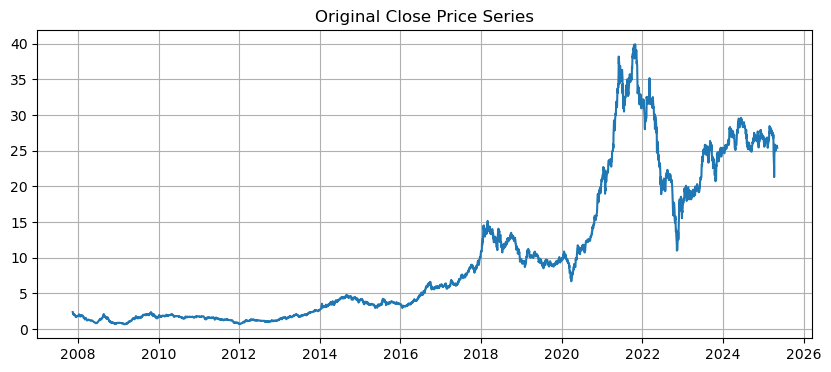

In [4]:
plt.figure(figsize=(10, 4))
plt.plot(series)
plt.title("Original Close Price Series")
plt.grid(True)
plt.show()

In [5]:
adf_result = adfuller(series)
print("ADF Statistic:", adf_result[0])
print("p-value:", adf_result[1])
print("Critical Values:", adf_result[4])

ADF Statistic: -0.8820268518048782
p-value: 0.793833599620505
Critical Values: {'1%': -3.431864627292699, '5%': -2.8622092782958526, '10%': -2.567126261627658}



After 1st differencing:
ADF Statistic: -10.688740670012356
p-value: 3.7736644880708687e-19
Critical Values: {'1%': -3.4318649781908066, '5%': -2.862209433310026, '10%': -2.567126344149579}


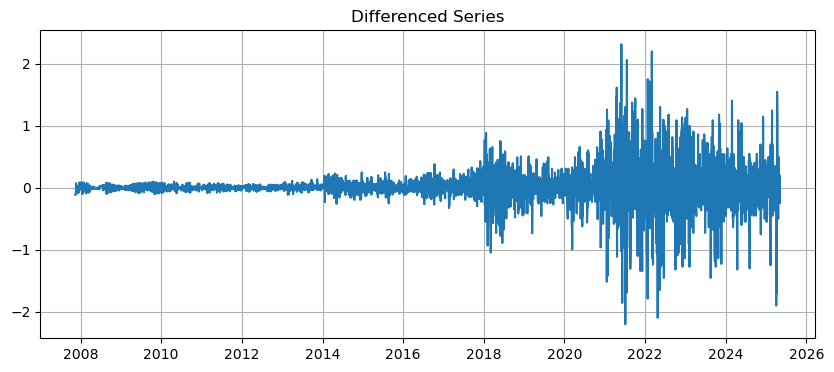

In [6]:
d = 0
if adf_result[1] > 0.05:
    d = 1
    series_diff = series.diff().dropna()
    adf_diff_result = adfuller(series_diff)
    print("\nAfter 1st differencing:")
    print("ADF Statistic:", adf_diff_result[0])
    print("p-value:", adf_diff_result[1])
    print("Critical Values:", adf_diff_result[4])

    # Plot differenced series
    plt.figure(figsize=(10, 4))
    plt.plot(series_diff)
    plt.title("Differenced Series")
    plt.grid(True)
    plt.show()
else:
    series_diff = series

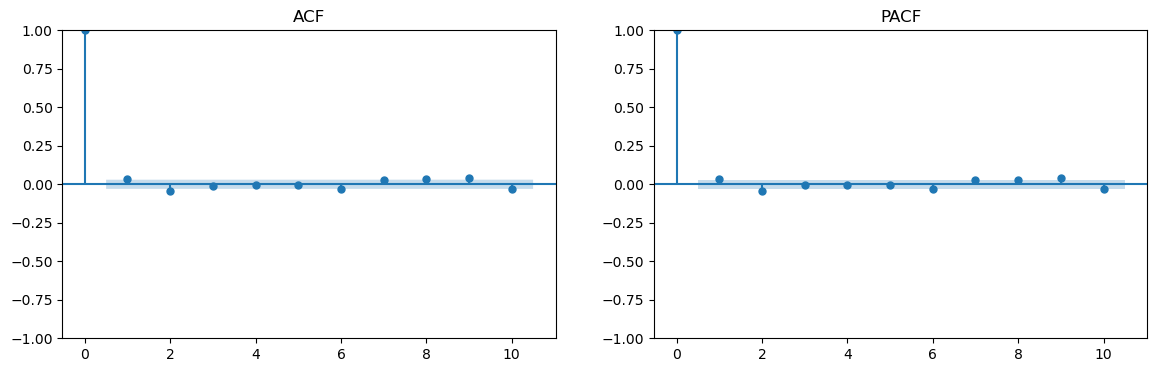

In [7]:
fig, axes = plt.subplots(1, 2, figsize=(14, 4))
plot_acf(series_diff, ax=axes[0], lags=10)
plot_pacf(series_diff, ax=axes[1], lags=10)
axes[0].set_title("ACF")
axes[1].set_title("PACF")
plt.show()

In [12]:
best_aic = float("inf")
best_bic = float("inf")
best_avg = float("inf")
best_order = None
results_table = []

for p in range(4):
    for q in range(4):
        try:
            model = ARIMA(series, order=(p, d, q)).fit()
            aic = model.aic
            bic = model.bic
            avg = (aic+bic)/2
            results_table.append((p, d, q, aic, bic))
            if avg < best_avg:
                best_aic = aic
                best_bic = bic
                best_avg = avg
                best_order = (p, d, q)
        except:
            continue



In [13]:
results_df = pd.DataFrame(results_table, columns=["p", "d", "q", "AIC", "BIC"])
print("\nAll tried models:")
print(results_df.sort_values("AIC"))

print(f"\n✅ Best model: ARIMA{best_order} with AIC={best_aic:.2f}, BIC={best_bic:.2f}")


All tried models:
    p  d  q          AIC          BIC
15  3  1  3  1624.750163  1669.397290
5   1  1  1  1624.969904  1644.104387
7   1  1  3  1625.646736  1657.537540
11  2  1  3  1626.348541  1664.617507
8   2  1  0  1627.905882  1647.040365
2   0  1  2  1628.090163  1647.224646
6   1  1  2  1629.574961  1655.087605
3   0  1  3  1629.631135  1655.143779
9   2  1  1  1629.638310  1655.150954
12  3  1  0  1629.674922  1655.187566
10  2  1  2  1631.576170  1663.466975
13  3  1  1  1631.678576  1663.569381
1   0  1  1  1633.051084  1645.807406
14  3  1  2  1633.520925  1671.789891
4   1  1  0  1633.575712  1646.332034
0   0  1  0  1637.463576  1643.841737

✅ Best model: ARIMA(1, 1, 1) with AIC=1624.97, BIC=1644.10


In [30]:
best_model = ARIMA(series, order=best_order).fit()
forecast_steps = 300
forecast = best_model.forecast(steps=forecast_steps)
future_dates = pd.date_range(start=series.index[-1] + pd.Timedelta(days=1), periods=forecast_steps, freq='B')

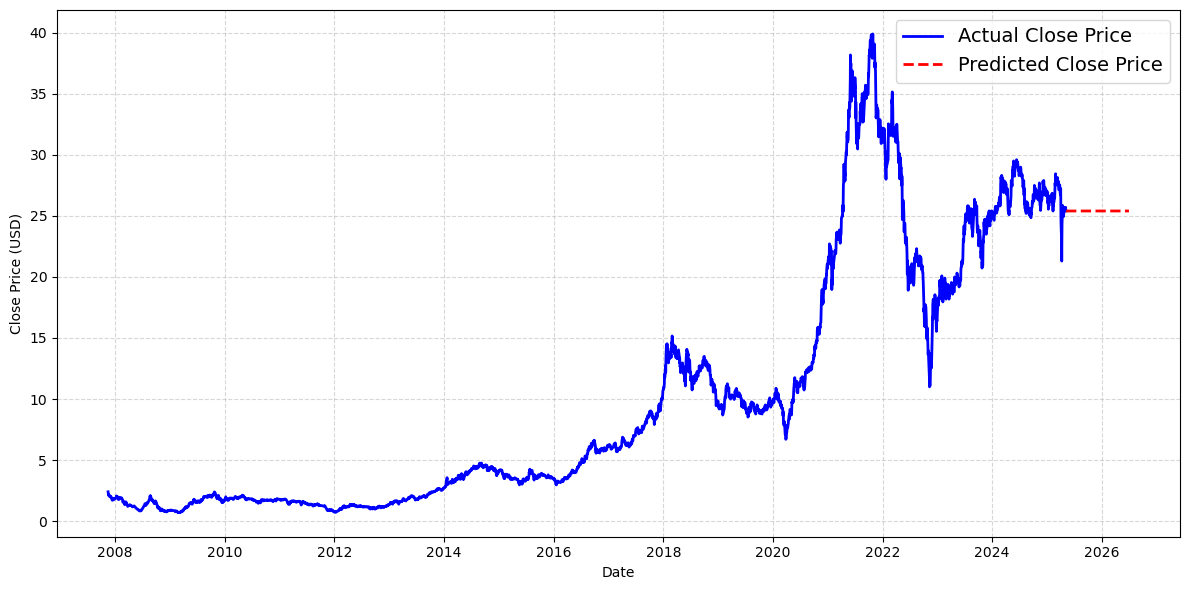

In [31]:
plt.figure(figsize=(12, 6))

# Plot actual close price (original)
plt.plot(series, color='blue', linewidth=2, label='Actual Close Price')

# Plot forecasted values (predicted)
plt.plot(future_dates, forecast, color='red', linestyle='--', linewidth=2, label='Predicted Close Price')

# Formatting
plt.xlabel('Date', fontsize=10)
plt.ylabel('Close Price (USD)', fontsize=10)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend(fontsize=14)
plt.tight_layout()
plt.show()

In [32]:
print("\nForecasted Close Prices:")
print(forecast)


Forecasted Close Prices:
4352    25.406428
4353    25.400823
4354    25.405710
4355    25.401449
4356    25.405165
          ...    
4647    25.403434
4648    25.403434
4649    25.403434
4650    25.403434
4651    25.403434
Name: predicted_mean, Length: 300, dtype: float64
